In [56]:
import pandas as pd
import numpy as np
import json
import swifter
import nltk
import string
import re
import ast
import emoji_data_python
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import codecs
from matplotlib import pyplot as plt
import seaborn as sns

# Posts

## load data

In [65]:
df_comments = pd.read_csv("./rb_data/all_comments.csv", header=0)
df_users = pd.read_csv("./rb_data/all_users.csv", header=0)
df_posts = pd.read_csv("./rb_data/all_posts.csv", header=0)
df_report_user = pd.read_csv("./rb_data/all_report_user.csv", header=0)

In [118]:
df_socks_assigns = pd.read_csv('./assigns/sockpuppet_assigned.csv', header=0)

In [119]:
len(df_socks_assigns)

210

In [120]:
# filter our missing data
df_posts = df_posts[df_posts['AuthorId'].notna()]

### Assign roles

In [32]:
df_users.head()

,id,email,username,password,firstName,lastName,fullName,profilePic,isMod,isObserver,instructions,createdAt,updatedAt,isPuppet,suspicious,disabled
0,1976,miho@dartpost.com,miho,$2a$10$9NrDj7dEYDHgK4vL0kTCbOmY07dM/ptcF2dVD8J...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-28 20:01:01.253+00,2020-08-28 20:01:01.253+00,f,f,f
1,1977,ModBessler@dartpost.org,ModB,$2a$10$iyHu9zlIoZ5JW7ErGgfCvueRa3tMGPfx6GlkE//...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-28 20:15:20.792+00,2020-08-28 20:15:20.792+00,f,f,f
2,1980,dapang@dartpost.com,RuiboLiu,$2a$10$dxRTsGeeutRAWhpYOGTwwek2x2CgGxvKeEfKmqQ...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-28 20:20:59.307+00,2020-08-28 20:20:59.307+00,f,f,f
3,1981,ruiliu@dartpost.org,ruiliu,$2a$10$dXK/0H8f9uaYixNAEvrsBO/XoldMqsg4Q9K5J/q...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-29 21:04:59.74+00,2020-08-29 21:04:59.74+00,f,f,f
4,1982,blake@dartpost.com,sarah_king,$2a$10$jevIf3bniJDDK7lebLGicO0T1W/Xg/Q1yj.icca...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-09-01 20:20:02.988+00,2020-09-01 20:20:02.988+00,f,f,f


In [31]:
sockpuppets, participants, observers = [], [], []
for idx, row in df_users.iterrows():
    if 'dartpost' in row['email']:
        participants.append(row['id'])
    if 'observer' in row['email']:
        observers.append(row['id'])
    if 'sockpuppet' in row['email']:
        sockpuppets.append(row['id'])

In [37]:
observers[:10]

[2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283]

14

In [51]:
df_posts['AuthorId'] = [int(id) for id in df_posts['AuthorId'].tolist()]

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
def return_role(text):
    if text in participants:
        return 'participant'
    if text in observers:
        return 'observer'
    else:
        return 'sockpuppet'

df_posts['role'] = df_posts['AuthorId'].swifter.allow_dask_on_strings().apply(return_role)

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [54]:
df_posts['role'].value_counts()

participant    760
sockpuppet     310
Name: role, dtype: int64

### Posts processing

In [175]:
df_posts.head()

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,create_day_time,update_day_time,create_hour_time,update_hour_time
0,93,I think that we should move away from nuclear ...,NaN,NaN,NaN,f,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051+00,2020-09-04 13:08:51.133+00,2580.0,f,1,2,01:59,13:08
1,94,"Given the security put in place since 911, it ...",NaN,NaN,NaN,f,{TerroristAttack},2020-09-03 02:28:29.002+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:28,13:08
2,95,NaN,NaN,NaN,NaN,t,"{""""}",2020-09-03 02:31:10.028+00,2020-09-03 02:34:29.992+00,2611.0,f,1,1,02:31,02:34
3,96,It is crucial that the United States plays a r...,NaN,NaN,NaN,f,{Worldaffairs},2020-09-03 02:34:07.312+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:34,13:08
4,97,Strongly disapprove of a two percent annual ta...,NaN,NaN,NaN,f,{WealthTax},2020-09-03 02:36:27.825+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:36,13:08


In [5]:
def preprocess_tweet(text):
    import nltk
    import string
    import re
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    nopunc = re.sub(r"[^a-zA-Z.,!?]+", r" ", nopunc)
    return nopunc

### time preprocessing

In [75]:
def return_day_time(text):
    date = text.split(' ')[0].strip()
    if date in '2020-09-03':
        return 1
    elif date in '2020-09-04':
        return 2
    elif date in '2020-09-05':
        return 3
    elif date in '2020-09-06':
        return 4
    elif date in '2020-09-07':
        return 5
    elif date in '2020-09-08':
        return 6

def return_hour_time(text):
    return ':'.join(text.split()[1].split(':')[:2])

def return_roles(text):
    if int(text) in observers:
        return 'oberserver'
    elif int(text) in participants:
        return 'participant'
    else:
        return 'sockpuppet'

In [76]:
df_posts['create_day_time'] = df_posts['createdAt'].swifter.allow_dask_on_strings().apply(return_day_time)
df_posts['update_day_time'] = df_posts['updatedAt'].swifter.allow_dask_on_strings().apply(return_day_time)
df_posts['create_hour_time'] = df_posts['createdAt'].swifter.allow_dask_on_strings().apply(return_hour_time)
df_posts['update_hour_time'] = df_posts['updatedAt'].swifter.allow_dask_on_strings().apply(return_hour_time)

In [77]:
df_posts.head()

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,create_day_time,update_day_time,create_hour_time,update_hour_time
0,93,I think that we should move away from nuclear ...,NaN,NaN,NaN,f,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051+00,2020-09-04 13:08:51.133+00,2580.0,f,1,2,01:59,13:08
1,94,"Given the security put in place since 911, it ...",NaN,NaN,NaN,f,{TerroristAttack},2020-09-03 02:28:29.002+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:28,13:08
2,95,NaN,NaN,NaN,NaN,t,"{""""}",2020-09-03 02:31:10.028+00,2020-09-03 02:34:29.992+00,2611.0,f,1,1,02:31,02:34
3,96,It is crucial that the United States plays a r...,NaN,NaN,NaN,f,{Worldaffairs},2020-09-03 02:34:07.312+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:34,13:08
4,97,Strongly disapprove of a two percent annual ta...,NaN,NaN,NaN,f,{WealthTax},2020-09-03 02:36:27.825+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:36,13:08


In [78]:
df_posts['create_day_time'].value_counts()

1    354
2    211
3    162
4    160
5    150
6     47
Name: create_day_time, dtype: int64

## Load User Report

In [66]:
df_report_user.head()

,id,report,createdAt,updatedAt,ReporterId,SuspectId
0,14,They do not go into enough detail and do not d...,2020-09-03 03:24:23.636+00,2020-09-03 03:24:23.636+00,2638,2604
1,15,"His comment, “thank you China,” is inappropria...",2020-09-03 19:38:37.22+00,2020-09-03 19:38:37.22+00,2593,2560
2,16,I think it is a bot account,2020-09-03 20:21:50.501+00,2020-09-03 20:21:50.501+00,2588,2604
3,17,Possible bot,2020-09-03 20:40:12.567+00,2020-09-03 20:40:12.567+00,2588,2638
4,18,Bot?,2020-09-04 13:31:00.079+00,2020-09-04 13:31:00.079+00,2588,2658


In [79]:
df_report_user['create_day_time'] = df_report_user['createdAt'].swifter.allow_dask_on_strings().apply(return_day_time)
df_report_user['update_day_time'] = df_report_user['updatedAt'].swifter.allow_dask_on_strings().apply(return_day_time)
df_report_user['create_hour_time'] = df_report_user['createdAt'].swifter.allow_dask_on_strings().apply(return_hour_time)
df_report_user['update_hour_time'] = df_report_user['updatedAt'].swifter.allow_dask_on_strings().apply(return_hour_time)

In [80]:
df_report_user.head()

,id,report,createdAt,updatedAt,ReporterId,SuspectId,create_day_time,update_day_time,create_hour_time,update_hour_time
0,14,They do not go into enough detail and do not d...,2020-09-03 03:24:23.636+00,2020-09-03 03:24:23.636+00,2638,2604,1,1,03:24,03:24
1,15,"His comment, “thank you China,” is inappropria...",2020-09-03 19:38:37.22+00,2020-09-03 19:38:37.22+00,2593,2560,1,1,19:38,19:38
2,16,I think it is a bot account,2020-09-03 20:21:50.501+00,2020-09-03 20:21:50.501+00,2588,2604,1,1,20:21,20:21
3,17,Possible bot,2020-09-03 20:40:12.567+00,2020-09-03 20:40:12.567+00,2588,2638,1,1,20:40,20:40
4,18,Bot?,2020-09-04 13:31:00.079+00,2020-09-04 13:31:00.079+00,2588,2658,2,2,13:31,13:31


In [83]:
# ndet(a)=1/e^((T-D_a))

def sock_reward(text):
    return 1 / np.exp(6-text)

df_report_user['sock_reward'] = df_report_user['create_day_time'].swifter.allow_dask_on_strings().apply(sock_reward)

In [84]:
df_report_user.head()

,id,report,createdAt,updatedAt,ReporterId,SuspectId,create_day_time,update_day_time,create_hour_time,update_hour_time,sock_reward
0,14,They do not go into enough detail and do not d...,2020-09-03 03:24:23.636+00,2020-09-03 03:24:23.636+00,2638,2604,1,1,03:24,03:24,0.006738
1,15,"His comment, “thank you China,” is inappropria...",2020-09-03 19:38:37.22+00,2020-09-03 19:38:37.22+00,2593,2560,1,1,19:38,19:38,0.006738
2,16,I think it is a bot account,2020-09-03 20:21:50.501+00,2020-09-03 20:21:50.501+00,2588,2604,1,1,20:21,20:21,0.006738
3,17,Possible bot,2020-09-03 20:40:12.567+00,2020-09-03 20:40:12.567+00,2588,2638,1,1,20:40,20:40,0.006738
4,18,Bot?,2020-09-04 13:31:00.079+00,2020-09-04 13:31:00.079+00,2588,2658,2,2,13:31,13:31,0.018316


In [87]:
def return_valid(text):
    if text in sockpuppets:
        return True
    else:
        return False

df_report_user['is_valid'] = df_report_user['SuspectId'].swifter.allow_dask_on_strings().apply(return_valid)

In [88]:
df_report_user.head()

,id,report,createdAt,updatedAt,ReporterId,SuspectId,create_day_time,update_day_time,create_hour_time,update_hour_time,sock_reward,is_valid
0,14,They do not go into enough detail and do not d...,2020-09-03 03:24:23.636+00,2020-09-03 03:24:23.636+00,2638,2604,1,1,03:24,03:24,0.006738,False
1,15,"His comment, “thank you China,” is inappropria...",2020-09-03 19:38:37.22+00,2020-09-03 19:38:37.22+00,2593,2560,1,1,19:38,19:38,0.006738,True
2,16,I think it is a bot account,2020-09-03 20:21:50.501+00,2020-09-03 20:21:50.501+00,2588,2604,1,1,20:21,20:21,0.006738,False
3,17,Possible bot,2020-09-03 20:40:12.567+00,2020-09-03 20:40:12.567+00,2588,2638,1,1,20:40,20:40,0.006738,False
4,18,Bot?,2020-09-04 13:31:00.079+00,2020-09-04 13:31:00.079+00,2588,2658,2,2,13:31,13:31,0.018316,False


In [90]:
df_report_user['is_valid'].value_counts()

False    34
True     12
Name: is_valid, dtype: int64

In [126]:
df_report_user.head()

,id,report,createdAt,updatedAt,ReporterId,SuspectId,create_day_time,update_day_time,create_hour_time,update_hour_time,sock_reward,is_valid
0,14,They do not go into enough detail and do not d...,2020-09-03 03:24:23.636+00,2020-09-03 03:24:23.636+00,2638,2604,1,1,03:24,03:24,0.006738,False
1,15,"His comment, “thank you China,” is inappropria...",2020-09-03 19:38:37.22+00,2020-09-03 19:38:37.22+00,2593,2560,1,1,19:38,19:38,0.006738,True
2,16,I think it is a bot account,2020-09-03 20:21:50.501+00,2020-09-03 20:21:50.501+00,2588,2604,1,1,20:21,20:21,0.006738,False
3,17,Possible bot,2020-09-03 20:40:12.567+00,2020-09-03 20:40:12.567+00,2588,2638,1,1,20:40,20:40,0.006738,False
4,18,Bot?,2020-09-04 13:31:00.079+00,2020-09-04 13:31:00.079+00,2588,2658,2,2,13:31,13:31,0.018316,False


In [94]:
valid_report = df_report_user[df_report_user['is_valid'] == True]

In [134]:
valid_report = valid_report.reset_index()
del valid_report['index']

In [145]:
valid_report.loc[0, 'strategy'] = 'dapang'

In [153]:
for idx, row in valid_report.iterrows():
    user_df = df_users[df_users['id'] == row['SuspectId']]
    user_email = user_df['email'].tolist()[0]
    valid_report.loc[idx, 'strategy'] = df_socks_assigns[df_socks_assigns['email'].str.contains(user_email)]['strategy'].tolist()[0]

In [222]:
valid_report

,id,report,createdAt,updatedAt,ReporterId,SuspectId,create_day_time,update_day_time,create_hour_time,update_hour_time,sock_reward,is_valid,strategy
0,15,"His comment, “thank you China,” is inappropria...",2020-09-03 19:38:37.22+00,2020-09-03 19:38:37.22+00,2593,2560,1,1,19:38,19:38,0.006738,True,UNRESTRICTED
1,20,Fake profile,2020-09-04 16:26:47.842+00,2020-09-04 16:26:47.842+00,2603,2455,2,2,16:26,16:26,0.018316,True,COVERT
2,22,r2,2020-09-04 21:06:58.771+00,2020-09-04 21:06:58.771+00,2704,2441,2,2,21:06,21:06,0.018316,True,OVERT
3,24,r2,2020-09-04 21:09:42.661+00,2020-09-04 21:09:42.661+00,2704,2530,2,2,21:09,21:09,0.018316,True,OVERT
4,27,multiple repeat posts. seems fake.,2020-09-04 22:23:41.362+00,2020-09-04 22:23:41.362+00,2655,2426,2,2,22:23,22:23,0.018316,True,COVERT
5,46,possible bot,2020-09-06 15:19:30.601+00,2020-09-06 15:19:30.601+00,2588,2390,4,4,15:19,15:19,0.135335,True,COVERT
6,52,r2,2020-09-07 02:50:55.144+00,2020-09-07 02:50:55.144+00,2704,2456,5,5,02:50,02:50,0.367879,True,COVERT
7,53,r2,2020-09-07 05:44:24.706+00,2020-09-07 05:44:24.706+00,2709,2455,5,5,05:44,05:44,0.367879,True,COVERT
8,54,I think they are a sock puppet posting to get ...,2020-09-07 09:29:24.146+00,2020-09-07 09:29:24.146+00,2750,2455,5,5,09:29,09:29,0.367879,True,COVERT
9,55,r2,2020-09-07 14:34:01.717+00,2020-09-07 14:34:01.717+00,2709,2566,5,5,14:34,14:34,0.367879,True,OVERT


In [209]:
valid_report['SuspectId'].tolist()

[2560, 2455, 2441, 2530, 2426, 2390, 2456, 2455, 2455, 2566, 2566, 2455]

In [257]:
valid_report[valid_report['strategy'] == 'UNRESTRICTED']['sock_reward']

0    0.006738
Name: sock_reward, dtype: float64

In [258]:
valid_report[valid_report['strategy'] == 'COVERT']['sock_reward']

1     0.018316
4     0.018316
5     0.135335
6     0.367879
7     0.367879
8     0.367879
11    1.000000
Name: sock_reward, dtype: float64

In [259]:
valid_report[valid_report['strategy'] == 'OVERT']['sock_reward']

2     0.018316
3     0.018316
9     0.367879
10    0.367879
Name: sock_reward, dtype: float64

In [155]:
valid_report['strategy'].value_counts()

COVERT          7
OVERT           4
UNRESTRICTED    1
Name: strategy, dtype: int64

In [170]:
len(df_socks_assigns)

210

In [157]:
df_socks_assigns['strategy'].value_counts()

OVERT           81
UNRESTRICTED    73
COVERT          56
Name: strategy, dtype: int64

In [160]:
valid_report[valid_report['strategy'] == 'COVERT']['create_day_time']

1     2
4     2
5     4
6     5
7     5
8     5
11    6
Name: create_day_time, dtype: int64

In [240]:
discover_time = {2560: 1, 2455: 2, 2441: 2, 2530: 2, 2426: 2, 2390: 4, 2456: 5, 2455: 5, 2566: 5}

In [239]:
discover_time[2560]

1

# Graph 1

In [171]:
gh1_df = pd.read_csv('./graph_data/graph_1.csv', header=0)

In [172]:
gh1_df.head()

,day,num_sock_discover,num_sock_discover_ratio,strategy
0,1,0,0.0,OVERT
1,1,1,1.4,UNRESTRICTED
2,1,0,0.0,COVERT
3,1,1,0.5,ALL
4,2,2,2.5,OVERT


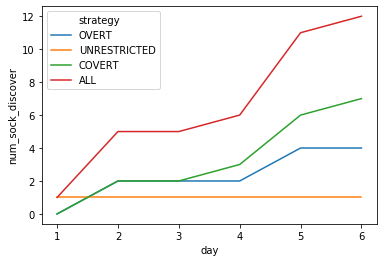

In [173]:
gh_1 = sns.lineplot(x="day", y="num_sock_discover",
             hue="strategy",
             data=gh1_df)
gh_1.figure.savefig('graph_1.pdf')

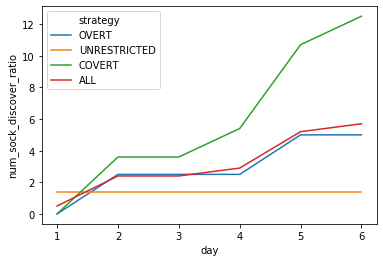

In [174]:
gh_1 = sns.lineplot(x="day", y="num_sock_discover_ratio",
             hue="strategy",
             data=gh1_df)
gh_1.figure.savefig('graph_1_ratio.pdf')

# Graph 2

In [176]:
df_posts.head()

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,create_day_time,update_day_time,create_hour_time,update_hour_time
0,93,I think that we should move away from nuclear ...,NaN,NaN,NaN,f,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051+00,2020-09-04 13:08:51.133+00,2580.0,f,1,2,01:59,13:08
1,94,"Given the security put in place since 911, it ...",NaN,NaN,NaN,f,{TerroristAttack},2020-09-03 02:28:29.002+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:28,13:08
2,95,NaN,NaN,NaN,NaN,t,"{""""}",2020-09-03 02:31:10.028+00,2020-09-03 02:34:29.992+00,2611.0,f,1,1,02:31,02:34
3,96,It is crucial that the United States plays a r...,NaN,NaN,NaN,f,{Worldaffairs},2020-09-03 02:34:07.312+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:34,13:08
4,97,Strongly disapprove of a two percent annual ta...,NaN,NaN,NaN,f,{WealthTax},2020-09-03 02:36:27.825+00,2020-09-04 13:08:51.133+00,2593.0,f,1,2,02:36,13:08


In [179]:
retweet_posts = df_posts[df_posts['root_id'].notna()]

In [225]:
len(retweet_posts)

123

In [223]:
def return_valid(text):
    if text in sockpuppets:
        return True
    else:
        return False

retweet_posts['sockpuppet_retweet'] = retweet_posts['AuthorId'].swifter.allow_dask_on_strings().apply(return_valid)

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [230]:
retweet_posts = retweet_posts[retweet_posts['sockpuppet_retweet']]

In [231]:
retweet_posts

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,create_day_time,update_day_time,create_hour_time,update_hour_time,sockpuppet_retweet,discovered
25,118,Absolutely! The preservation of the environmen...,NaN,93.0,93.0,f,NaN,2020-09-03 06:05:01.123+00,2020-09-03 06:05:01.135+00,2444.0,f,1,1,06:05,06:05,True,False
26,119,"Of course! The economy can wait, destruction o...",NaN,109.0,109.0,f,NaN,2020-09-03 06:08:59.136+00,2020-09-03 06:08:59.147+00,2444.0,f,1,1,06:08,06:08,True,False
54,147,2 pennies out of every dollar! It's such a sma...,NaN,129.0,129.0,f,NaN,2020-09-03 12:24:48.395+00,2020-09-03 12:24:48.404+00,2481.0,f,1,1,12:24,12:24,True,False
158,251,I disagree strongly.\n\nHonestly I don't think...,NaN,97.0,97.0,f,NaN,2020-09-03 19:09:31.166+00,2020-09-04 20:12:07.119+00,2540.0,f,1,2,19:09,20:12,True,False
166,259,"I have to agree, we've actually historically t...",NaN,129.0,129.0,f,NaN,2020-09-03 19:43:14.571+00,2020-09-03 19:43:14.579+00,2545.0,f,1,1,19:43,19:43,True,False
168,261,"This is terrible. In times like these, we nee...",NaN,150.0,150.0,f,NaN,2020-09-03 19:54:08.23+00,2020-09-04 22:28:59.206+00,2543.0,f,1,2,19:54,22:28,True,False
182,275,Agreed! #earthfirst,NaN,109.0,109.0,f,NaN,2020-09-03 20:18:17.76+00,2020-09-04 22:28:59.206+00,2529.0,f,1,2,20:18,22:28,True,False
198,291,YAAAAS,NaN,109.0,109.0,f,NaN,2020-09-03 20:34:56.011+00,2020-09-04 22:28:59.206+00,2531.0,f,1,2,20:34,22:28,True,False
458,551,exactly right. I agree. This is an important g...,NaN,264.0,264.0,f,NaN,2020-09-04 14:19:45.132+00,2020-09-04 14:19:45.138+00,2391.0,f,2,2,14:19,14:19,True,False
492,585,LOVE THIS,NaN,174.0,174.0,f,NaN,2020-09-04 15:21:46.664+00,2020-09-04 15:21:48.382+00,2531.0,f,2,2,15:21,15:21,True,False


In [227]:
for idx, row in retweet_posts.iterrows():
    id = row['AuthorId']
    if id in valid_report['SuspectId'].tolist():
        retweet_posts.loc[idx, 'discovered'] = True
    else:
        retweet_posts.loc[idx, 'discovered'] = False 

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [232]:
retweet_posts['discovered'].value_counts()

False    38
True      3
Name: discovered, dtype: int64

In [233]:
retweet_posts[retweet_posts['discovered']]

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,create_day_time,update_day_time,create_hour_time,update_hour_time,sockpuppet_retweet,discovered
762,855,NaN,NaN,708.0,708.0,f,NaN,2020-09-06 03:48:24.221+00,2020-09-06 03:48:24.229+00,2455.0,f,4,4,03:48,03:48,True,True
995,1088,"really, this is over the top. Trump is really ...",NaN,747.0,747.0,f,NaN,2020-09-07 15:58:31.445+00,2020-09-07 15:58:31.46+00,2390.0,f,5,5,15:58,15:58,True,True
996,1089,Hope you are able to stay out of flame's way. ...,NaN,426.0,426.0,f,NaN,2020-09-07 16:04:06.318+00,2020-09-07 16:04:06.328+00,2390.0,f,5,5,16:04,16:04,True,True


In [189]:
df_comments['sockpuppet_comment'] = df_comments['CommenterId'].swifter.allow_dask_on_strings().apply(return_valid)

In [191]:
sum(df_comments['sockpuppet_comment'])

437

In [192]:
sock_comments = df_comments[df_comments['sockpuppet_comment']]

In [194]:
for idx, row in sock_comments.iterrows():
    user_df = df_users[df_users['id'] == row['CommenterId']]
    user_email = user_df['email'].tolist()[0]
    sock_comments.loc[idx, 'strategy'] = df_socks_assigns[df_socks_assigns['email'].str.contains(user_email)]['strategy'].tolist()[0]

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [196]:
sock_comments['create_day_time'] = sock_comments['createdAt'].swifter.allow_dask_on_strings().apply(return_day_time)
sock_comments['update_day_time'] = sock_comments['updatedAt'].swifter.allow_dask_on_strings().apply(return_day_time)
sock_comments['create_hour_time'] = sock_comments['createdAt'].swifter.allow_dask_on_strings().apply(return_hour_time)
sock_comments['update_hour_time'] = sock_comments['updatedAt'].swifter.allow_dask_on_strings().apply(return_hour_time)

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [198]:
sock_comments.head(3)

,id,text,createdAt,updatedAt,PostId,CommenterId,sockpuppet_comment,strategy,create_day_time,update_day_time,create_hour_time,update_hour_time
83,154,"Yeah, what Alison_5893 said.",2020-09-03 05:49:49.656+00,2020-09-03 05:49:49.684+00,111.0,2540.0,True,COVERT,1,1,05:49,05:49
84,156,Yeah. Wish it wasn't true but that's the way ...,2020-09-03 05:56:40+00,2020-09-03 05:56:40.022+00,104.0,2541.0,True,COVERT,1,1,05:56,05:56
85,157,Where's the money gonna come from?,2020-09-03 05:58:45.628+00,2020-09-03 05:58:45.65+00,96.0,2541.0,True,COVERT,1,1,05:58,05:58


In [252]:

df_comments['create_day_time'] = df_comments['createdAt'].swifter.allow_dask_on_strings().apply(return_day_time)
df_comments['update_day_time'] = df_comments['updatedAt'].swifter.allow_dask_on_strings().apply(return_day_time)
df_comments['create_hour_time'] = df_comments['createdAt'].swifter.allow_dask_on_strings().apply(return_hour_time)
df_comments['update_hour_time'] = df_comments['updatedAt'].swifter.allow_dask_on_strings().apply(return_hour_time)

In [253]:
df_comments['create_day_time'].value_counts()


[305, 554, 880, 1173, 1528, 1620]

5    355
3    326
1    305
4    293
2    249
6     92
Name: create_day_time, dtype: int64

In [242]:
# sock_comments[sock_comments['discovered']]['CommenterId']
for idx, row in sock_comments.iterrows():
    if row['CommenterId'] in discover_time.keys():
        sock_comments.loc[idx, 'discover_time'] = discover_time[row['CommenterId']]
    else:
        sock_comments.loc[idx, 'discover_time'] = None

In [245]:
sock_comments['discover_time'].value_counts()

5.0    48
4.0    45
1.0    24
Name: discover_time, dtype: int64

In [203]:
sock_comments[sock_comments['strategy'] == 'UNRESTRICTED']['create_day_time'].value_counts()

5    34
4    25
1    25
Name: create_day_time, dtype: int64

In [254]:
gh2_df = pd.read_csv('./graph_data/graph_2_comments.csv', header=0)

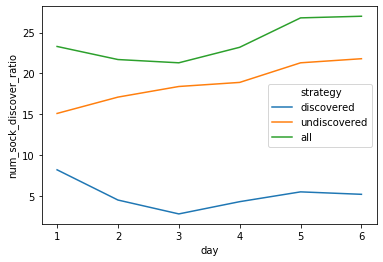

In [256]:
gh_2 = sns.lineplot(x="day", y="num_sock_discover_ratio",
             hue="strategy",
             data=gh2_df)
gh_2.figure.savefig('graph_2_comments.pdf')

In [214]:
for idx, row in sock_comments.iterrows():
    id = row['CommenterId']
    if id in valid_report['SuspectId'].tolist():
        sock_comments.loc[idx, 'discovered'] = True
    else:
        sock_comments.loc[idx, 'discovered'] = False 

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [216]:
sum(sock_comments['discovered'])

117

In [217]:
len(sock_comments)

437

In [219]:
sum(sock_comments['sockpuppet_comment'])

437